# SD201 : MINING OF LARGE DATASETS

## MUSIC GENRE CLASSIFICATION USING SONG LYRICS

In [102]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### 1. DATA PREPROCESSING

In [103]:
# loading the dataset from csv file
data = pd.read_csv("lyrics.csv", sep='#')

In [104]:
# inspecting the content of the dataset
data.head()

,artist,title,lyrics,genre,url
0,Eminem,Rap God,"Rap God Lyrics\r\n""Look, I was gonna go easy o...",rap,https://genius.com/Eminem-rap-god-lyrics
1,Cardi B,WAP,WAP Lyrics\r\nWhores in this house\r\nThere's ...,rap,https://genius.com/Cardi-b-wap-lyrics
2,Kendrick Lamar,HUMBLE.,HUMBLE. Lyrics\r\nNobody pray for me\r\nIt bee...,rap,https://genius.com/Kendrick-lamar-humble-lyrics
3,Migos,Bad and Boujee,"Bad and Boujee Lyrics\r\nYou know, young rich ...",rap,https://genius.com/Migos-bad-and-boujee-lyrics
4,Drake,God's Plan,God’s Plan Lyrics\r\nAnd they wishin' and wish...,rap,https://genius.com/Drake-gods-plan-lyrics


In [105]:
# size of the dataset
data.shape

(6858, 5)

In [106]:
#Missing values
data.isna().sum()[data.isna().sum() > 0]

lyrics    25
dtype: int64

In [107]:
# Deleting rows with missing values
data.dropna(inplace=True)
data.reset_index(drop=True, inplace=True)

In [108]:
#Check missing values (check is dropping went right)
data.isna().sum()


artist    0
title     0
lyrics    0
genre     0
url       0
dtype: int64

In [109]:


for i in range(0,len(data['lyrics'])):
    data['lyrics'][i] = data['lyrics'][i].split('Lyrics')[1]
    

In [111]:
data

,artist,title,lyrics,genre,url
0,Eminem,Rap God,"\r\n""Look, I was gonna go easy on you not to h...",rap,https://genius.com/Eminem-rap-god-lyrics
1,Cardi B,WAP,\r\nWhores in this house\r\nThere's some whore...,rap,https://genius.com/Cardi-b-wap-lyrics
2,Kendrick Lamar,HUMBLE.,\r\nNobody pray for me\r\nIt been that day for...,rap,https://genius.com/Kendrick-lamar-humble-lyrics
3,Migos,Bad and Boujee,"\r\nYou know, young rich niggas\r\nYou know so...",rap,https://genius.com/Migos-bad-and-boujee-lyrics
4,Drake,God's Plan,\r\nAnd they wishin' and wishin'\r\nAnd wishin...,rap,https://genius.com/Drake-gods-plan-lyrics
...,...,...,...,...,...
6828,MAVI,Terms & Conditions,\r\nTo be pro black\r\nMeans to relentlessly p...,jazz,https://genius.com/Mavi-terms-and-conditions-l...
6829,Nina Simone,22nd Century,There is no oxygen in the air\r\nMen and women...,jazz,https://genius.com/Nina-simone-22nd-century-ly...
6830,Jon Batiste,CRY,\r\nWho do you love?\r\nWho you gonna love?\r\...,jazz,https://genius.com/Jon-batiste-cry-lyrics
6831,Frank Sinatra,Once In Love With Amy,"Once in love with Amy, always in love with Amy...",jazz,https://genius.com/Frank-sinatra-once-in-love-...


### 2. DATA VISUALISATION

<AxesSubplot:>

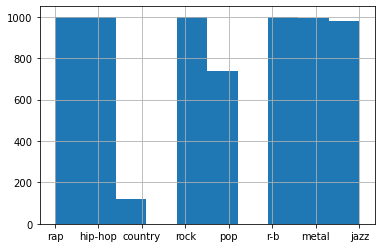

In [112]:
data['genre'].hist()

### 3. DATA MODELING